## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

In [2]:
#Read in the data
combined_df = pd.read_csv('data/cleandata.csv')

# Exploratory Data Analysis

In [3]:
combined_df.isnull().sum()

author       0
title        2
selftext     2
subreddit    0
dtype: int64

In [4]:
null_columns=combined_df.columns[combined_df.isnull().any()]
combined_df[null_columns].isnull().sum().sort_values(ascending=False)

selftext    2
title       2
dtype: int64

In [5]:
#drop NAN rows
combined_df.dropna(inplace = True)

In [6]:
master_df = combined_df.groupby('subreddit').count()
master_df.rename(index = {0 : 'learnmachinelearning', 1: 'learnprogramming'}, inplace = True)

In [7]:
master_df

,author,title,selftext
subreddit,,,
learnmachinelearning,684,684,684
learnprogramming,973,973,973


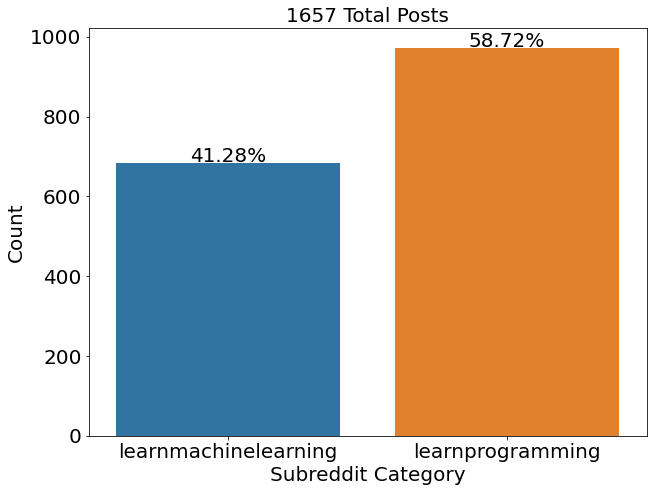

In [8]:
fig = plt.figure(figsize=(10, 7.5))
total = sum(master_df.selftext)
ax = sns.barplot(x = master_df.index, y = master_df.selftext)
ax.set_title('{} Total Posts'.format(total), fontsize = 20)
ax.set_xlabel('Subreddit Category', fontsize = 20)
ax.set_ylabel('Count', fontsize = 20)
ax.tick_params(labelsize=20)

for p in ax.patches:
    ax.annotate('{}%'.format(round(p.get_height()/total * 100, 2) ), (p.get_x() + p.get_width() / 2, p.get_height() + 15), 
                ha = 'center', va = 'center',size = 20)


In [9]:
def create_wordcloud(data, title):
    wordcloud = WordCloud(
        background_color='black',
        max_words=500,
        max_font_size=70,
        scale=3).generate(str(data))

    fig = plt.figure(1, figsize=(12, 10))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

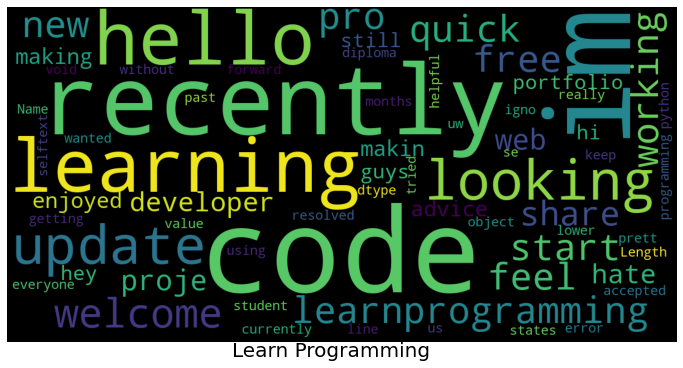

In [10]:
create_wordcloud(combined_df['selftext'][combined_df['subreddit'] == 1], 'Learn Programming')


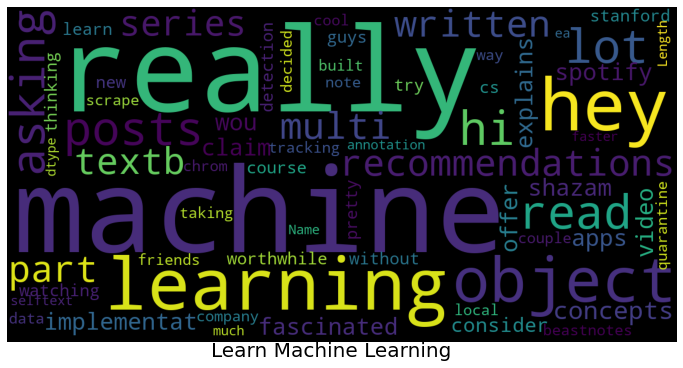

In [11]:
create_wordcloud(combined_df['selftext'][combined_df['subreddit'] == 0], 'Learn Machine Learning')

## Top Words

Count vectorizer provides us with the count of words to help us identify the top common 20 words. 

We will identify the column of interest for easier manipulation and set them as X and y.

In [12]:
X = combined_df['selftext']
y = combined_df['subreddit']

In [13]:
# only words appearing in minimum 20 documents and select a maximum of 2000 features

cvec = CountVectorizer(min_df = 20, max_features = 2000)
common_cvec = cvec.fit_transform(X)
common_cvec = pd.DataFrame(common_cvec.todense(), 
                        columns=cvec.get_feature_names())

In [14]:
# Create a data frame of the most common words 

n_words = 20
words = list(common_cvec.sum().sort_values(ascending=False)[:n_words].index)
common_cvec['subreddit'] = y.values
cvec_train_small = common_cvec.groupby('subreddit').sum()[words]

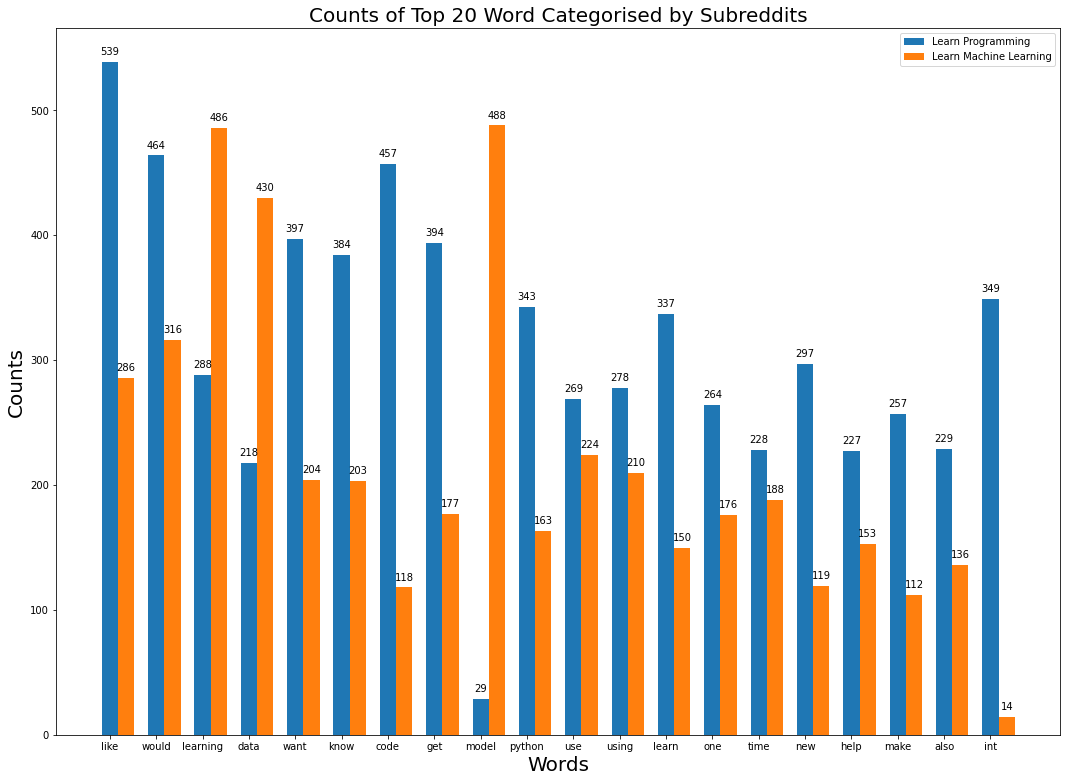

In [15]:
words_program = words
words_count_program = cvec_train_small.loc[1]
words_ml = words
words_count_ml = cvec_train_small.loc[0]
width = 0.35       
ind = np.arange(n_words)

fig, ax = plt.subplots(figsize=(18, 13))
rects1 = ax.bar(ind, words_count_program, width)
rects2 = ax.bar(ind+width, words_count_ml, width)

# add some text for labels, title and axes ticks
ax.set_ylabel('Counts', fontsize = 20)
ax.set_xlabel('Words', fontsize = 20)
ax.set_title('Counts of Top 20 Word Categorised by Subreddits', fontsize = 20)
ax.set_xticks(ind)
ax.set_xticklabels(words)

ax.legend((rects1[0], rects2[0]), ('Learn Programming', 'Learn Machine Learning'))

for p in ax.patches:
    ax.annotate(format(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points', size = 10)

plt.show()

In [16]:
def subplot_graphs(list_veccounts, list_of_titles, list_of_xlabels):
    nrows = int(np.ceil(len(list_veccounts)/2)) 
    fig, ax = plt.subplots(nrows=nrows, ncols=2, figsize=(20,10)) 
    ax = ax.ravel() 
    for i in range(len(list_veccounts)): 
        ax[i].barh(list_veccounts[i].keys(),width=list_veccounts[i],color='b')
        ax[i].set_title(list_of_titles[i],fontsize=20)
        ax[i].set_xlabel(list_of_xlabels[i],fontsize=16)
        ax[i].set_ylabel('Word', fontsize=16)
        ax[i].tick_params(axis="x", labelsize=14)
        ax[i].tick_params(axis="y", labelsize=14)
    plt.tight_layout()

def plot_graph(data,title_suffix):
  
    cvec = CountVectorizer()
    tvec = TfidfVectorizer()

    # Explore CountVectorizer token counts
    cvec_count = pd.DataFrame(cvec.fit_transform(data).todense(),
                           columns=cvec.get_feature_names()).sum(axis=0)

    # Explore TfidfVectorizer token count
    tvec_count = pd.DataFrame(tvec.fit_transform(data).todense(),
                           columns=tvec.get_feature_names()).sum(axis=0)
    
    subplot_graphs([cvec_count.sort_values(ascending=False).head(20),tvec_count.sort_values(ascending=False).head(20)],
                   ['Top 20 CountVectorized Words in '+title_suffix,'Top 20 TfidfVectorized Words in '+title_suffix],
                   ['count','tfidf value'])

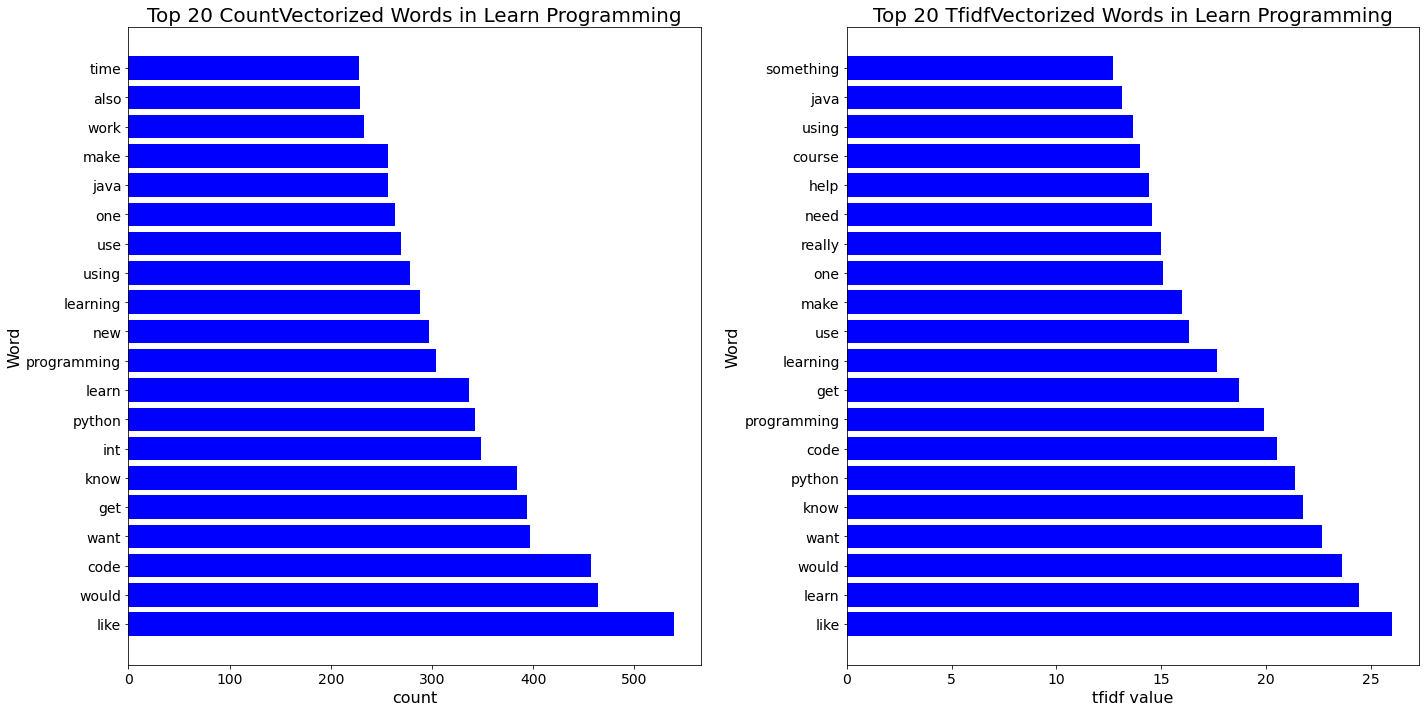

In [17]:
plot_graph(combined_df['selftext'][combined_df['subreddit'] == 1],'Learn Programming')


## Feature Engineering

In [18]:
common_cvec = common_cvec.groupby('subreddit').sum()
common_words = []

for words in common_cvec:
    if (abs(common_cvec[words].loc[0] - common_cvec[words].loc[1]) < 60):
        common_words.append(words)

In [19]:
len(common_words)

671

In [20]:
def lemmatize(selftext):
    lemmatizer = WordNetLemmatizer()
    tokenizer = RegexpTokenizer(r'\w+')
    return [lemmatizer.lemmatize(word) for word in tokenizer.tokenize(selftext)]

combined_df['lemma_text'] = combined_df.selftext.apply(lemmatize)
combined_df['lemma_text']= combined_df['lemma_text'].str.join(' ')

In [21]:
def stemming(selftext):
    p_stemmer = PorterStemmer()
    tokenizer = RegexpTokenizer(r'\w+')
    return [p_stemmer.stem(word) for word in tokenizer.tokenize(selftext)]

combined_df['stem_text'] = combined_df.selftext.apply(stemming)
combined_df['stem_text']= combined_df['stem_text'].str.join(' ')

In [22]:
# Function for gridsearch

def pipeline_gridsearch(pipe, pipe_params, X_train, y_train):
    gs = GridSearchCV(pipe, param_grid=pipe_params, cv=5)
    gs.fit(X_train, y_train)
    print(gs.best_score_) # best_score_ is gridsearch's function
    print(gs.best_params_)# best_params_ is gridsearch's function

In [23]:
# Function for fit, test and predict after getting optimum parameters

def fit_and_test(best_feature, best_model, X_train, X_test, y_train, y_test):
    X_train_featured = best_feature.fit_transform(X_train)
    X_test_featured = best_feature.transform(X_test)
    best_model.fit(X_train_featured, y_train)
    train_score = cross_val_score(best_model, X_train_featured, y_train, cv=10)
    train_score = best_model.score(X_train_featured, y_train)
    test_score = best_model.score(X_test_featured, y_test)
    selected_features = best_feature.get_feature_names()
    
    coef = best_model.coef_  
    predict = best_model.predict(X_test_featured)
    report = classification_report(y_test, best_model.predict(X_test_featured))
    con_matrix = confusion_matrix(y_test, predict)
    tn, fp, fn, tp = confusion_matrix(y_test, predict).ravel()
    probabilities = best_model.predict_proba(X_test_featured)
    
    print('{} features were selected'.format(len(selected_features)))
    print('Cross Validated Mean Train Score is: {}'.format(train_score.mean()))
    print('Test Score is: {}'.format(test_score))
    
   
    return (coef, predict, con_matrix, report, tn, fp, fn, tp, probabilities)

## Selecting Original, Lemma or Stemmed Text
We will use count vectorizer with logistic regression followed by tfidf vectorizer with logistic regression to run a test on each of the 3 text to see which has the higher score. The one with the highest score will be the text used during the modeling prepping and modelling stage.

In [24]:
best_cvec = CountVectorizer(stop_words = common_words)
best_logreg = LogisticRegression(solver = 'lbfgs')

In [25]:
columns = ['selftext', 'stem_text', 'lemma_text']

for i in columns:
    X = combined_df[i]
    y = combined_df['subreddit']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify = y,
                                                    test_size = 0.25,
                                                    random_state = 42)
    
    print(i)
    fit_and_test(best_cvec, best_logreg, X_train, X_test, y_train, y_test)
    print('')

selftext
8498 features were selected
Cross Validated Mean Train Score is: 0.9927536231884058
Test Score is: 0.9180722891566265

stem_text
6119 features were selected
Cross Validated Mean Train Score is: 0.9935587761674718
Test Score is: 0.927710843373494

lemma_text
7667 features were selected
Cross Validated Mean Train Score is: 0.9919484702093397
Test Score is: 0.9132530120481928



## Modelling
Stem test achieved the best result and will be used for modelling

In [26]:
X = combined_df['stem_text']
y = combined_df['subreddit']

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify = y,
                                                    test_size = 0.25,
                                                    random_state = 42)

## Model 1 - Count Vectorizer with Naive Bayesian's Multinomial NB¶
We first call our function to run a pipeline and grid search to determine the optimum hyperparameter from those which we had selected ones

In [28]:
pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words = common_words)),
    ('nb', MultinomialNB())])

In [29]:
pipe_params = {
    'cvec__max_features': [None, 5000], # find out how many max features is better
    'cvec__min_df': [1, 3], # find out how many min documents the word is required to appear for it to be counted
    'cvec__max_df': [.09, 1.0], # find out what is the best perimeter to ignore words whether the words appear in 90% or 95% of documents
    'cvec__ngram_range': [(1,1), (1,2)], # find out what is the best ngram to use
    
    'nb__alpha': [1.0, 3.0],
    'nb__fit_prior' : [True, False]
}

In [30]:
best_params = pipeline_gridsearch(pipe, pipe_params, X_train, y_train)

0.9203005570669776
{'cvec__max_df': 1.0, 'cvec__max_features': 5000, 'cvec__min_df': 1, 'cvec__ngram_range': (1, 2), 'nb__alpha': 3.0, 'nb__fit_prior': False}


In [31]:
best_cvec = CountVectorizer(max_df = 1.0, max_features = None, min_df = 1, ngram_range = (1, 2), stop_words = common_words)
best_nb = MultinomialNB(alpha = 1.0, fit_prior = True)

In [32]:
m1_coef, m1_predict, m1_con_matrix, m1_report, m1_tn, m1_fp, m1_fn, m1_tp, m1_probabilities = fit_and_test(best_cvec, best_nb, X_train, X_test, y_train, y_test)

45806 features were selected
Cross Validated Mean Train Score is: 0.9903381642512077
Test Score is: 0.9228915662650602


In [33]:
m1_df = pd.DataFrame(m1_coef.T, index=best_cvec.get_feature_names(), columns=['coef'])

In [34]:
m1_df.coef.sort_values(ascending=False).head(30)

learn      -5.405545
code       -5.541027
like       -5.610339
get        -5.695178
want       -5.748667
program    -5.754176
work       -5.811010
would      -5.852807
know       -5.922235
int        -5.975939
tri        -6.054833
make       -6.073666
new        -6.207741
start      -6.207741
java       -6.261325
python     -6.275182
need       -6.308282
class      -6.308282
help       -6.332614
one        -6.342515
go         -6.362617
realli     -6.458435
cours      -6.475336
file       -6.486765
function   -6.515922
languag    -6.539875
return     -6.545954
way        -6.552070
creat      -6.558224
also       -6.570647
Name: coef, dtype: float64

In [35]:
# https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers

def important_features(best_cvec,best_nb,n=20):
    class_labels = best_nb.classes_
    feature_names =best_cvec.get_feature_names()
    topn_class1 = sorted(zip(best_nb.feature_count_[0], feature_names),reverse=True)[:n]
    topn_class2 = sorted(zip(best_nb.feature_count_[1], feature_names),reverse=True)[:n]
    print("Important words for learnmachinelearning")
    for coef, feat in topn_class1:
        print(class_labels[0], coef, feat)
    print("-----------------------------------------\n")
    print("Important words for learnprogramming")
    for coef, feat in topn_class2:
        print(class_labels[1], coef, feat)

In [36]:
important_features(best_cvec, best_nb, 15)

Important words for learnmachinelearning
0 482.0 learn
0 440.0 model
0 320.0 data
0 244.0 train
0 231.0 would
0 206.0 machin
0 203.0 like
0 197.0 work
0 193.0 machin learn
0 188.0 want
0 169.0 imag
0 165.0 get
0 164.0 ml
0 163.0 know
0 160.0 tri
-----------------------------------------

Important words for learnprogramming
1 512.0 learn
1 447.0 code
1 417.0 like
1 383.0 get
1 363.0 want
1 361.0 program
1 341.0 work
1 327.0 would
1 305.0 know
1 289.0 int
1 267.0 tri
1 262.0 make
1 229.0 start
1 229.0 new
1 217.0 java


In [37]:
# pred learningmachinelearning = 0 (Negative)
# pred learnprogramming = 1 (Positive)

cm1_df = pd.DataFrame(m1_con_matrix, columns=['Pred Machine Learning', 'Pred Learn Programming'], index=['Actual Learn Machine Learning', 'Actual Learn Programming'])
cm1_df

,Pred Machine Learning,Pred Learn Programming
Actual Learn Machine Learning,154,17
Actual Learn Programming,15,229


In [38]:
print(m1_report)

              precision    recall  f1-score   support

           0       0.91      0.90      0.91       171
           1       0.93      0.94      0.93       244

    accuracy                           0.92       415
   macro avg       0.92      0.92      0.92       415
weighted avg       0.92      0.92      0.92       415



In [39]:
X_test_featured = best_cvec.transform(X_test)

In [40]:
predictions = best_nb.predict(X_test_featured)


In [41]:
y_pred = pd.Series(predictions)
y_pred.index = y_test.index

In [42]:
predicted = y_test!=predictions

misclassify_df = pd.DataFrame({'text':X_test[predicted],'actual':y_test[predicted],'predicted':y_pred[predicted]})
misclassify_df.head(20)

,text,actual,predicted
345,hi tri fill array work c tri find better way b...,1,0
1658,hey compani beastnot built note take chrome ex...,0,1
1641,hey anyon experi use raspberri pi python tenso...,0,1
780,would answer question interview recent ask heu...,1,0
388,new industri dont know requir e data scientist...,1,0
1576,word run inform without risk avail public,0,1
1435,tri get head around legal came across apach li...,0,1
33,reason know repli would appreci,1,0
4,hey guy current im diploma student im pretti n...,1,0
1461,recommend,0,1


In [43]:
# confirming the indx 1658
input_txt = X_test.loc[1658]
print(input_txt)

print(y_test.loc[1658])

hey compani beastnot built note take chrome extens design work coursera uniqu featur allow note take browser watch lectur longer paus flip browser take note free use first three coursebook wrote articl want learn
0


In [44]:
for i in misclassify_df[(misclassify_df['actual'] - misclassify_df['predicted']) < 0]['text']:
    print(i)
    print('-'*10)

hey compani beastnot built note take chrome extens design work coursera uniqu featur allow note take browser watch lectur longer paus flip browser take note free use first three coursebook wrote articl want learn
----------
hey anyon experi use raspberri pi python tensor current research rn worri like know data set go use train run slow pc know littl pi use extern process unit addit pc run pi help direct gener would appreci thank
----------
word run inform without risk avail public
----------
tri get head around legal came across apach licens one facebook repo allow use commerci purpos wonder would avenu allow use code titl ask would legal compos code read research paper use commerci product thank
----------
recommend
----------
found aw sagemak handi jump run ml code annoy upload download file ui copi privat github key set ssh month ago final decid write guid hope go help
----------
hello would like creat custom real time object detect app prefer pytorch peopl download mac pc linux wi

## Model 2 - Tfidf Vectorizer with Naive Bayesian's Multinomial NB

In [45]:
pipe = Pipeline([
    ('tvec', TfidfVectorizer(stop_words = common_words)),
    ('nb', MultinomialNB())])

In [46]:
pipe_params = {
    'tvec__max_features': [None, 5000], # find out how many max features is better
    'tvec__min_df': [1, 2], # find out how many min documents the word is required to appear for it to be counted
    'tvec__max_df': [0.9, 1.0], # find out what is the best perimeter to ignore words whether the words appear in 90% or 95% of documents
    'tvec__ngram_range': [(1,1), (1,2)], # find out what is the best ngram to use
    
    'nb__alpha': [1.0, 3.0],
    'nb__fit_prior' : [True, False]
}

In [47]:
best_params = pipeline_gridsearch(pipe, pipe_params, X_train, y_train)

0.9122360409379453
{'nb__alpha': 1.0, 'nb__fit_prior': False, 'tvec__max_df': 0.9, 'tvec__max_features': 5000, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 2)}


In [48]:
best_tvec = TfidfVectorizer(max_df = 0.9, max_features = 5000, min_df = 1, ngram_range = (1, 2), stop_words = common_words)
best_nb = MultinomialNB(alpha = 3.0, fit_prior = False)

In [49]:
coef, predict, con_matrix, report, tn, fp, fn, tp, probabilities = fit_and_test(best_tvec, best_nb, X_train, X_test, y_train, y_test)

5000 features were selected
Cross Validated Mean Train Score is: 0.9508856682769726
Test Score is: 0.9012048192771084


## Model 3 - Tfidf Vectorizer with Logistic Regression

In [50]:
pipe = Pipeline([
    ('tvec', TfidfVectorizer(stop_words = common_words)),
    ('lr', LogisticRegression(solver = 'liblinear'))])

In [51]:

pipe_params = {
    'tvec__max_features': [None, 5000], # find out how many max features is better
    'tvec__min_df': [1, 2], # find out how many min documents the word is required to appear for it to be counted
    'tvec__max_df': [0.9, 1.0], # find out what is the best perimeter to ignore words whether the words appear in 90% or 95% of documents
    'tvec__ngram_range': [(1,1), (1,2)], # find out what is the best ngram to use
        
    'lr__C': [1.0, 0.5],
    'lr__class_weight' : [None, 'balanced'],
    'lr__penalty' : ['l1', 'l2']
}

In [52]:
best_params = pipeline_gridsearch(pipe, pipe_params, X_train, y_train)

0.9106328539966316
{'lr__C': 1.0, 'lr__class_weight': 'balanced', 'lr__penalty': 'l2', 'tvec__max_df': 0.9, 'tvec__max_features': None, 'tvec__min_df': 1, 'tvec__ngram_range': (1, 2)}


In [53]:
best_tvec = TfidfVectorizer(max_df = 0.9, max_features = None, min_df = 2, ngram_range = (1, 2), stop_words = common_words)
best_logreg = LogisticRegression(C = 1.0, class_weight = None, penalty = 'l2', solver = 'liblinear')

In [54]:
coef, predict, con_matrix, report, tn, fp,fn, tp, probabilities = fit_and_test(best_tvec, best_logreg, X_train, X_test, y_train, y_test)

6633 features were selected
Cross Validated Mean Train Score is: 0.9557165861513688
Test Score is: 0.9060240963855422


## Model 4 - Count Vectorizer With Logistic Regression

In [55]:
pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words = common_words)),
    ('lr', LogisticRegression(solver = 'liblinear'))])

In [56]:
pipe_params = {
    'cvec__max_features': [None, 5000], # find out how many max features is better
    'cvec__min_df': [1, 2], # find out how many min documents the word is required to appear for it to be counted
    'cvec__max_df': [0.9, 1.0], # find out what is the best perimeter to ignore words whether the words appear in 90% or 95% of documents
    'cvec__ngram_range': [(1, 1), (1, 2)], # find out what is the best ngram to use
            
    'lr__C': [1.0, 0.9],
    'lr__class_weight' : [None, 'balanced'],
    'lr__penalty' : ['l1', 'l2']
}

In [57]:
pipeline_gridsearch(pipe, pipe_params, X_train, y_train)

0.8864911257934965
{'cvec__max_df': 0.9, 'cvec__max_features': None, 'cvec__min_df': 1, 'cvec__ngram_range': (1, 2), 'lr__C': 0.9, 'lr__class_weight': 'balanced', 'lr__penalty': 'l2'}


In [58]:
best_cvec = CountVectorizer(max_df = 0.9, max_features = None, min_df = 1, ngram_range = (1, 2), stop_words = common_words)
best_logreg = LogisticRegression(C = 1.0, class_weight = None, penalty = 'l2', solver = 'lbfgs')

In [59]:
m4_coef, m4_predict, m4_con_matrix, m4_report, m4_tn, m4_fp, m4_fn, m4_tp, m4_probabilities = fit_and_test(best_cvec, best_logreg, X_train, X_test, y_train, y_test)


45806 features were selected
Cross Validated Mean Train Score is: 1.0
Test Score is: 0.9204819277108434


In [60]:
cm4_df = pd.DataFrame(m4_con_matrix, columns=['Pred Learn Machine Learning', 'Pred Learn Programming'], index=['Actual Learn Machine Learning', 'Actual Learn Programming'])
cm4_df

,Pred Learn Machine Learning,Pred Learn Programming
Actual Learn Machine Learning,148,23
Actual Learn Programming,10,234


In [61]:
print(m4_report)

              precision    recall  f1-score   support

           0       0.94      0.87      0.90       171
           1       0.91      0.96      0.93       244

    accuracy                           0.92       415
   macro avg       0.92      0.91      0.92       415
weighted avg       0.92      0.92      0.92       415



## Model 5: Count Vectorizer with Random Forest

In [69]:
pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words = common_words)),
    ('rf', RandomForestClassifier(criterion = 'gini', n_estimators=99, max_depth=9))])

pipe_params = {
    'cvec__max_features': [None, 5000], # find out how many max features is better
    'cvec__min_df': [1, 2], # find out how many min documents the word is required to appear for it to be counted
    'cvec__max_df': [0.9, 1.0], # find out what is the best perimeter to ignore words whether the words appear in 90% or 95% of documents
    'cvec__ngram_range': [(1, 1), (1, 2)], # find out what is the best ngram to use
    'rf__n_estimators': [100,200,300],
    'rf__max_depth':[50,75,100]
}
gs = GridSearchCV(pipe, param_grid=pipe_params, cv=5, verbose = 1)
gs.fit(X_train, y_train)
print(f"Best params: {gs.best_params_}")
print(f"Train score: {round(gs.best_score_, 4)}")
print(f"Test score: {round(gs.best_score_, 4)}")
print(f'Number of features: {len(gs.best_estimator_.named_steps.cvec.get_feature_names())}')


Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 720 out of 720 | elapsed: 12.1min finished


Best params: {'cvec__max_df': 0.9, 'cvec__max_features': None, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 1), 'rf__max_depth': 75, 'rf__n_estimators': 300}
Train score: 0.8881
Test score: (0.8881007902578053, 4)
Number of features: 2721


In [ ]:
y_test, y_pred

In [ ]:
rf_cvec = Pipeline([
    ('cvec', CountVectorizer(stop_words = common_words)),
    ('rf', RandomForestClassifier(criterion = 'gini', n_estimators=99, max_depth=9))])
rf_cvec.fit(X_train, y_train)
y_pred = rf_cvec.predict_proba(X_test)
y_pred = np.where(y_pred[:,1]>=0.5,1,0)

pipe.fit(X_train, y_train)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=['Pred Learn Machine Learning', 'Pred Learn Programming']))

## Model 6: Count Vectorizer with Random Forest

In [ ]:
pipe = Pipeline([
    ('tvec', TfidfVectorizer(stop_words = common_words)),
    ('rf', RandomForestClassifier(criterion = 'gini', n_estimators=99, max_depth=9))])

pipe_params = {
    'tvec__max_features': [None, 5000], # find out how many max features is better
    'tvec__min_df': [1, 2], # find out how many min documents the word is required to appear for it to be counted
    'tvec__max_df': [0.9, 1.0], # find out what is the best perimeter to ignore words whether the words appear in 90% or 95% of documents
    'tvec__ngram_range': [(1,1), (1,2)], # find out what is the best ngram to use
    'rf__n_estimators': [100,200,300],
    'rf__max_depth':[50,75,100]
}
gs = GridSearchCV(pipe, param_grid=pipe_params, cv=5, verbose = 1)
gs.fit(X_train, y_train)
print(f"Best params: {gs.best_params_}")
print(f"Train score: {round(gs.best_score_, 4)}")
print(f"Test score: {round(gs.best_estimator_.score(X_test, y_test), 4)}")
print(f'Number of features: {len(gs.best_estimator_.named_steps.tvec.get_feature_names())}')

In [ ]:
rf_tvec = Pipeline([
    ('tvec', CountVectorizer(stop_words = common_words)),
    ('rf', RandomForestClassifier(criterion = 'gini', n_estimators=99, max_depth=9))])
rf_tvec.fit(X_train, y_train)
y_pred = rf_tvec.predict_proba(X_test)
y_pred = np.where(y_pred[:,1]>=0.5,1,0)

pipe.fit(X_train, y_train)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=['0', '1']))

In [ ]:
pred_proba = [i[1] for i in m1_probabilities]

pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})

In [ ]:
pred_proba = [i[1] for i in m4_probabilities]

pred_df4 = pd.DataFrame({'true_values4': y_test,
                        'pred_probs4':pred_proba})

In [ ]:
y_pred = rf_tvec.predict_proba(X_test)

In [ ]:
# Create figure.
plt.figure(figsize = (10,7))

# Create two histograms of observations.
plt.hist(pred_df[pred_df['true_values'] == 0]['pred_probs'],
         bins=25,
         color='blue',
         alpha = 0.6,
         label='Outcome = Learn Machine Learning')
plt.hist(pred_df[pred_df['true_values'] == 1]['pred_probs'],
         bins=25,
         color='orange',
         alpha = 0.6,
         label='Outcome = Learn Programming')
plt.hist(pred_df4[pred_df4['true_values4'] == 0]['pred_probs4'],
         bins=25,
         color='green',
         alpha = 0.6,
         label='Outcome = Learn Machine Learning')
plt.hist(pred_df4[pred_df4['true_values4'] == 1]['pred_probs4'],
         bins=25,
         color='brown',
         alpha = 0.6,
         label='Outcome = Learn Programming')


# Add vertical line at P(Outcome = 1) = 0.5.
plt.vlines(x=0.5,
           ymin = 0,
           ymax = 140,
           color='r',
           linestyle = '--')

# Label axes.
plt.title('Distribution of P(Outcome = Learn Machine Learning)', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability that Outcome = Learn Programming', fontsize=18)

# Create legend.
plt.legend(fontsize=20);

In [ ]:
ROC1_Score = round(roc_auc_score(pred_df["true_values"], pred_df["pred_probs"]),3)
ROC1_Score

In [ ]:
ROC4_Score = round(roc_auc_score(pred_df4["true_values4"], pred_df4["pred_probs4"]),3)
ROC4_Score

In [ ]:
# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values. (Dashed red line in image.)
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
tpr4_values = [TPR(pred_df4, 'true_values4', 'pred_probs4', prob) for prob in thresholds]
fpr4_values = [FPR(pred_df4, 'true_values4', 'pred_probs4', prob) for prob in thresholds]


# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC1 Curve')

plt.plot(fpr4_values, # False Positive Rate on X-axis
         tpr4_values, # True Positive Rate on Y-axis
         label='ROC4 Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title(f'ROC Curve with AUC = {round(roc_auc_score(pred_df["true_values"], pred_df["pred_probs"]),3)}', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

plt.title(f'ROC Curve with AUC = {round(roc_auc_score(pred_df4["true_values4"], pred_df4["pred_probs4"]),3)}', fontsize=22)

# Create legend.
plt.legend(fontsize=16);
